In [1]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 11.0 MB/s eta 0:00:00



image 1/1 /content/midasyolotest4.jpg: 640x640 3 No helmets, 4 No vests, 5 Persons, 203.0ms
Speed: 6.2ms preprocess, 203.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


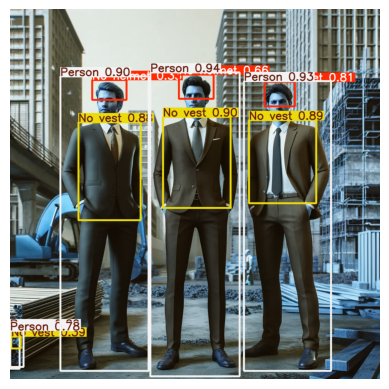

In [39]:
import torch
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
# Load the YOLO model from the specified file path
model_path = "/content/yolo11n-ppe-1111.pt"
image_path = "/content/midasyolotest4.jpg"

# Load the model
model = YOLO(model_path)
results = model(image_path)

# Get the annotated image
annotated_image = results[0].plot()  # Plots bounding boxes on the first result's image

# Display the annotated image
plt.imshow(annotated_image)
plt.axis('off')
plt.show()

In [52]:
# Add Detections
detections = results[0].boxes.data.tolist()

# Define classes, subject to change
NO_HELMET_CLASS = 0.0
NO_VEST_CLASS = 1.0
PERSON_CLASS = 2.0
HELMET_CLASS = 3.0
VEST_CLASS = 4.0

# Define confidence threshold
confidence_threshold = 0.8

# Separate detections by class with confidence filtering
people_detections = [det for det in detections if det[5] == PERSON_CLASS and det[4] >= confidence_threshold]
helmet_detections = [det for det in detections if det[5] == HELMET_CLASS and det[4] >= confidence_threshold]
vest_detections = [det for det in detections if det[5] == VEST_CLASS and det[4] >= confidence_threshold]
no_helmet_detections = [det for det in detections if det[5] == NO_HELMET_CLASS]
no_vest_detections = [det for det in detections if det[5] == NO_VEST_CLASS]
# List to store compliance results
compliance_results = []

# Function to check if a detected item overlaps with a person based on bounding box coordinates
def has_overlap(person_box, item_boxes, overlap_threshold=0.1):
    px_min, py_min, px_max, py_max = person_box[:4]

    for item_box in item_boxes:
        ix_min, iy_min, ix_max, iy_max = item_box[:4]

        # Calculate intersection coordinates
        inter_x_min = max(px_min, ix_min)
        inter_y_min = max(py_min, iy_min)
        inter_x_max = min(px_max, ix_max)
        inter_y_max = min(py_max, iy_max)

        # Calculate areas
        inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
        item_area = (ix_max - ix_min) * (iy_max - iy_min)

        # Calculate overlap ratio
        overlap_ratio = inter_area / item_area

        # Check if the overlap is above the threshold
        if overlap_ratio >= overlap_threshold:
            return True  # Sufficient overlap found

    return False  # No item met the overlap threshold

# Check PPE compliance for each detected person
for i, person in enumerate(people_detections, start=1):
    # Check for required and missing PPE
    has_helmet = has_overlap(person, helmet_detections)
    has_vest = has_overlap(person, vest_detections)
    no_helmet = has_overlap(person, no_helmet_detections)
    no_vest = has_overlap(person, no_vest_detections)

    # Check for "no helmet" or "no vest" first and add to missing items if detected
    missing_items = []
    if no_helmet:
        missing_items.append("helmet")
    if no_vest:
        missing_items.append("vest")

    if missing_items:
        compliance_results.append(f"Person {i} is non-compliant. Missing items: {', '.join(missing_items)}")
    elif has_helmet and has_vest:
        compliance_results.append(f"Person {i} is compliant.")
    else:
        if not has_helmet:
            missing_items.append("helmet")
        if not has_vest:
            missing_items.append("vest")
        compliance_results.append(f"Person {i} is non-compliant. Missing items: {', '.join(missing_items)}")

# Print the compliance results
for result in compliance_results:
    print(result)

Person 1 is non-compliant. Missing items: helmet, vest
Person 2 is non-compliant. Missing items: helmet, vest
Person 3 is non-compliant. Missing items: helmet, vest
